# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size"
    / "gls-1000g_mashr-sub_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size/gls-1000g_mashr-sub_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.009143,0.009555,-0.956967,0.338620,0.830690,random.pheno988
1,LV2,0.027460,0.012461,2.203737,0.027578,0.013789,random.pheno988
2,LV3,-0.011150,0.012298,-0.906587,0.364659,0.817670,random.pheno988
3,LV4,-0.013984,0.011958,-1.169454,0.242264,0.878868,random.pheno988
4,LV5,0.005710,0.012750,0.447805,0.654309,0.327154,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.055336372847011144

# QQ-plot

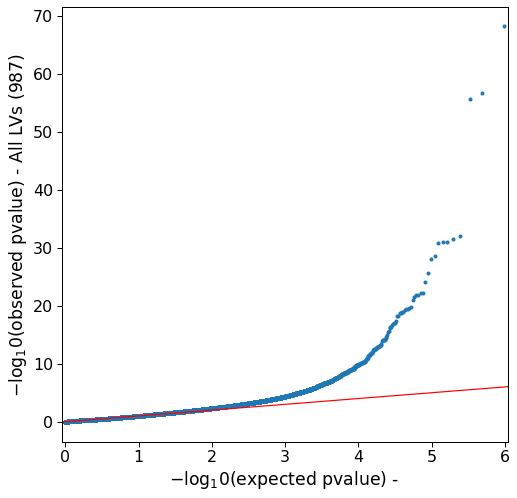

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.027,0.068
1,LV10,0.008,0.048,0.087
2,LV100,0.004,0.023,0.041
3,LV101,0.008,0.043,0.078
4,LV102,0.016,0.061,0.105


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016375,0.055336,0.099136
std,0.018383,0.033542,0.047584
min,0.000000,0.000000,0.000000
25%,0.008000,0.041000,0.081000
50%,0.014000,0.056000,0.103000
75%,0.020000,0.069000,0.123000
max,0.249000,0.344000,0.407000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(53, 4)

,lv,1,5,10
451,LV505,0.011,0.049,0.094
932,LV939,0.011,0.049,0.093
825,LV842,0.009,0.049,0.081
755,LV78,0.017,0.049,0.088
626,LV663,0.013,0.049,0.090
511,LV56,0.011,0.049,0.095
443,LV499,0.010,0.049,0.097
438,LV494,0.013,0.049,0.098
395,LV455,0.011,0.049,0.089
380,LV441,0.010,0.049,0.096


,lv,1,5,10
85,LV176,0.020,0.050,0.089
258,LV331,0.011,0.050,0.089
227,LV303,0.009,0.050,0.099
530,LV577,0.010,0.051,0.094
944,LV95,0.008,0.051,0.097
315,LV383,0.012,0.051,0.104
345,LV41,0.015,0.051,0.082
348,LV412,0.011,0.051,0.098
878,LV890,0.010,0.051,0.092
35,LV130,0.018,0.051,0.080


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(391, 4)

,lv,1,5,10
743,LV769,0.052,0.140,0.223
398,LV458,0.067,0.148,0.197
403,LV462,0.056,0.148,0.237
129,LV215,0.074,0.170,0.233
349,LV413,0.105,0.176,0.229
153,LV237,0.092,0.178,0.251
255,LV329,0.135,0.183,0.210
965,LV969,0.107,0.188,0.267
682,LV713,0.105,0.191,0.248
401,LV460,0.111,0.194,0.253


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.017201,0.010312,1.668058,0.095353,0.047676,random.pheno988
1031,LV45,0.010704,0.010317,1.037577,0.299506,0.149753,random.pheno589
2018,LV45,0.005137,0.010313,0.498132,0.618408,0.309204,random.pheno385
3005,LV45,0.006664,0.010305,0.646706,0.517845,0.258923,random.pheno5
3992,LV45,-0.016288,0.010302,-1.580998,0.113927,0.943036,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.023

In [32]:
show_prop(results, 0.05)

0.064

In [33]:
show_prop(results, 0.10)

0.121

In [34]:
show_prop(results, 0.15)

0.164

In [35]:
show_prop(results, 0.20)

0.202

### QQplot

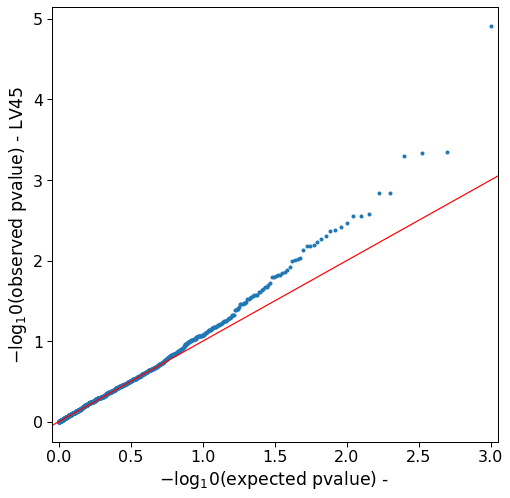

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.020061,0.012163,1.649347,0.099125,0.049563,random.pheno988
1220,LV234,0.000162,0.012148,0.013304,0.989386,0.494693,random.pheno589
2207,LV234,-0.012522,0.012139,-1.031560,0.302317,0.848841,random.pheno385
3194,LV234,0.008927,0.012142,0.735255,0.462211,0.231105,random.pheno5
4181,LV234,0.002352,0.012172,0.193254,0.846766,0.423383,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.017

In [43]:
show_prop(results, 0.05)

0.059

In [44]:
show_prop(results, 0.10)

0.109

In [45]:
show_prop(results, 0.15)

0.145

In [46]:
show_prop(results, 0.20)

0.179

### QQplot

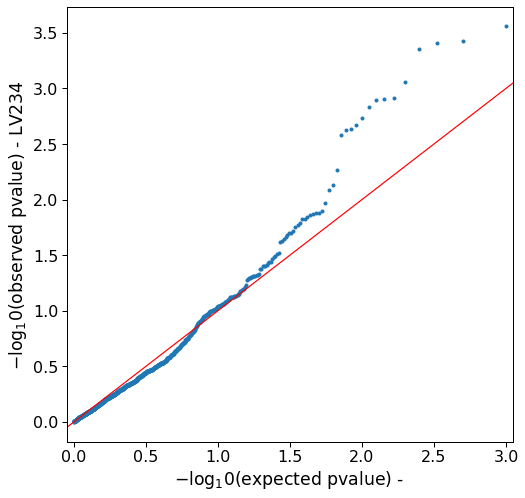

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.010503,0.012895,0.814527,0.415374,0.207687,random.pheno988
1833,LV847,0.003233,0.012915,0.250326,0.802343,0.401172,random.pheno589
2820,LV847,-0.015083,0.012894,-1.169728,0.242154,0.878923,random.pheno385
3807,LV847,0.007586,0.012882,0.588898,0.555951,0.277975,random.pheno5
4794,LV847,0.007825,0.012937,0.604838,0.545308,0.272654,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.024

In [54]:
show_prop(results, 0.05)

0.061

In [55]:
show_prop(results, 0.10)

0.102

In [56]:
show_prop(results, 0.15)

0.14

In [57]:
show_prop(results, 0.20)

0.189

### QQplot

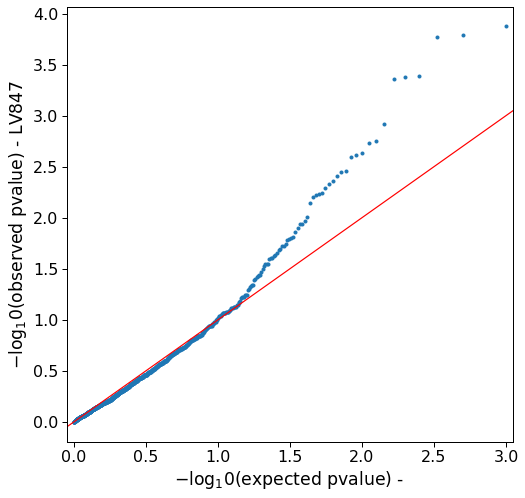

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.020540,0.013582,-1.512361,0.130491,0.934754,random.pheno988
1096,LV110,-0.007794,0.013588,-0.573620,0.566245,0.716878,random.pheno589
2083,LV110,-0.023734,0.013575,-1.748309,0.080458,0.959771,random.pheno385
3070,LV110,-0.011169,0.013539,-0.824947,0.409432,0.795284,random.pheno5
4057,LV110,-0.001396,0.013580,-0.102767,0.918151,0.540924,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.009

In [65]:
show_prop(results, 0.05)

0.037

In [66]:
show_prop(results, 0.10)

0.071

In [67]:
show_prop(results, 0.15)

0.112

In [68]:
show_prop(results, 0.20)

0.151

### QQplot

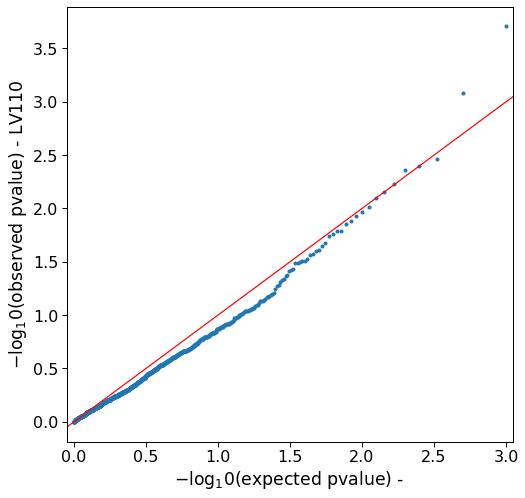

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.014415,0.011845,1.216954,0.223666,0.111833,random.pheno988
1755,LV769,0.002062,0.011807,0.174655,0.861356,0.430678,random.pheno589
2742,LV769,0.001926,0.011822,0.162929,0.870579,0.435290,random.pheno385
3729,LV769,-0.015003,0.011821,-1.269185,0.204421,0.897789,random.pheno5
4716,LV769,-0.019866,0.011846,-1.677011,0.093589,0.953206,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.052

In [76]:
show_prop(results, 0.05)

0.14

In [77]:
show_prop(results, 0.10)

0.223

In [78]:
show_prop(results, 0.15)

0.294

In [79]:
show_prop(results, 0.20)

0.347

### QQplot

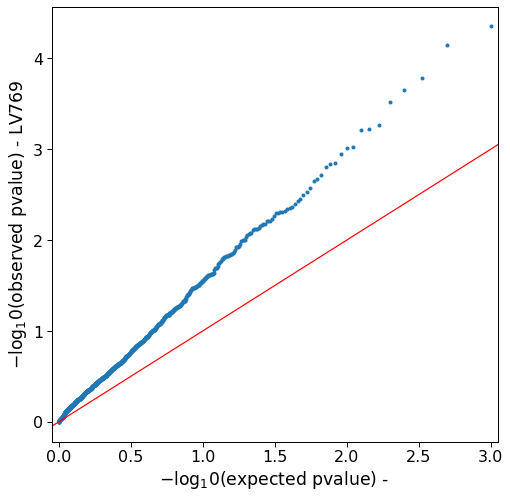

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.004965,0.014063,0.353064,0.724052,0.362026,random.pheno988
1786,LV800,-0.007198,0.014060,-0.511945,0.608707,0.695646,random.pheno589
2773,LV800,-0.003838,0.014078,-0.272628,0.785148,0.607426,random.pheno385
3760,LV800,-0.023092,0.014091,-1.638725,0.101319,0.949340,random.pheno5
4747,LV800,-0.012089,0.014032,-0.861534,0.388976,0.805512,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.008

In [87]:
show_prop(results, 0.05)

0.048

In [88]:
show_prop(results, 0.10)

0.086

In [89]:
show_prop(results, 0.15)

0.136

In [90]:
show_prop(results, 0.20)

0.189

### QQplot

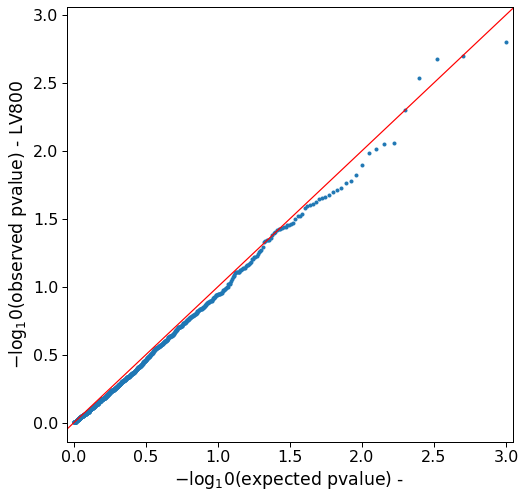

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
451,LV505,0.011,0.049,0.094
932,LV939,0.011,0.049,0.093
825,LV842,0.009,0.049,0.081
755,LV78,0.017,0.049,0.088
626,LV663,0.013,0.049,0.090
511,LV56,0.011,0.049,0.095
443,LV499,0.010,0.049,0.097
438,LV494,0.013,0.049,0.098
395,LV455,0.011,0.049,0.089
380,LV441,0.010,0.049,0.096


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.001267,0.010522,0.120396,0.904173,0.452087,random.pheno988
1398,LV412,-0.003249,0.010476,-0.310133,0.756470,0.621765,random.pheno589
2385,LV412,0.002792,0.010467,0.266713,0.789698,0.394849,random.pheno385
3372,LV412,-0.004594,0.010529,-0.436338,0.662606,0.668697,random.pheno5
4359,LV412,0.016521,0.010477,1.576874,0.114874,0.057437,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.011

In [100]:
show_prop(results, 0.05)

0.051

In [101]:
show_prop(results, 0.10)

0.098

In [102]:
show_prop(results, 0.15)

0.146

In [103]:
show_prop(results, 0.20)

0.187

### QQplot

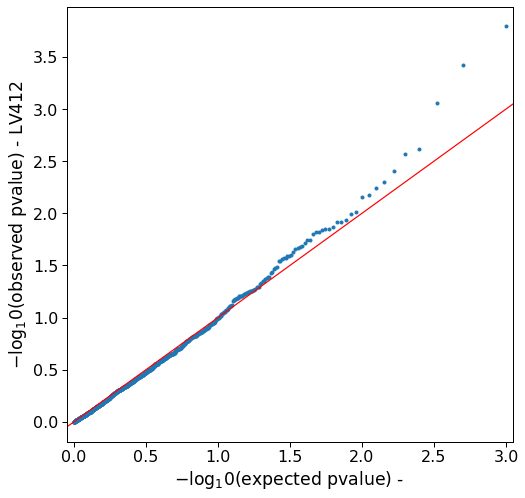

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.019022,0.012370,-1.537793,0.124148,0.937926,random.pheno988
1043,LV57,0.016616,0.012374,1.342846,0.179369,0.089685,random.pheno589
2030,LV57,0.018091,0.012376,1.461754,0.143857,0.071929,random.pheno385
3017,LV57,0.000376,0.012363,0.030445,0.975713,0.487857,random.pheno5
4004,LV57,0.013416,0.012339,1.087263,0.276961,0.138481,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.008

In [111]:
show_prop(results, 0.05)

0.056

In [112]:
show_prop(results, 0.10)

0.103

In [113]:
show_prop(results, 0.15)

0.145

In [114]:
show_prop(results, 0.20)

0.181

### QQplot

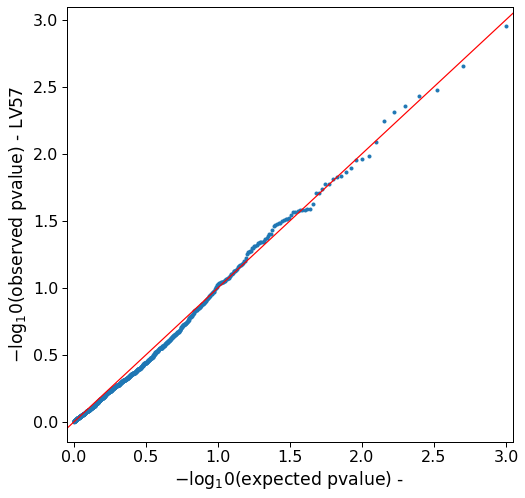

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.006638,0.011494,-0.577514,0.563613,0.718194,random.pheno988
1633,LV647,0.013944,0.011494,1.213222,0.225090,0.112545,random.pheno589
2620,LV647,0.012076,0.011491,1.050880,0.293353,0.146677,random.pheno385
3607,LV647,0.002718,0.011493,0.236486,0.813063,0.406531,random.pheno5
4594,LV647,0.014044,0.011467,1.224713,0.220728,0.110364,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.025

In [122]:
show_prop(results, 0.05)

0.075

In [123]:
show_prop(results, 0.10)

0.124

In [124]:
show_prop(results, 0.15)

0.17

In [125]:
show_prop(results, 0.20)

0.216

### QQplot

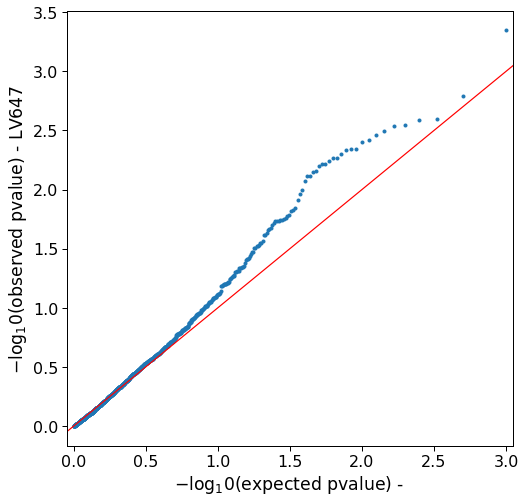

In [126]:
qqplot_unif(results)